# Solve an optimization problem using a parametric NLIW model

## Necessary data

 - Tidal amplitude at a point
 - Stratification parameters $\alpha$ and $c$.
 - Time series of NLIW amplitude, $A$
 
## Models

The optimization problem has the form

$$
A(t) = \hat{A}(t) a_0(t-\hat{T}(t))
$$

where $\hat{A}(t)$ is an amplitude distortion function, $a_0(t)$ is the initial internal tide amplitude, $\hat{T}(t)$ is a time lag function. The amplitude and time lag functions are determined empirically from ~O(10$^5$) KdV model solutions and are found to be functions of $\hat{L}$, the nondimensional steepening length scale, $L_s/L$, where 
$$
L_s = \frac{c^2}{\alpha \omega a_0}
$$
and $L$ is the distance from the generation site or the 'equivalent deep-water' site. This is the important link that we have identified. The amplitude function is

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = -A_{h} + 0.5(A_h - A_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_A}{0.5\delta_{lA}}\right) \right)
$$

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = 
$$
where $A_h$, $A_l$, $L_A$, $\delta_{lA}$ are all emirically determined parameters.  Similarly, the time lag function is

$$
\hat{T}(t) = \frac{T_{max} c}{L} =  f(\hat{L}) = -T_{h} + 0.5(T_h - T_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_T}{0.5\delta_{lT}}\right) \right)
$$
that also has four unknown parameters $T_h$, $T_l$, $L_T$, $\delta_{lT}$. The dimensional maximum amplitude, $A_{max}$, and time of maximum amplitude, $T_{max}$, are extracted from the KdV solutions and the parametric variables are found via...(least-squares, Bayesian inference...). 

The initial internal tide amplitude is unknown and we assume a linear relationship to the tidal elevation envelope, specifically

$$
a_0(t) = \beta_0 + \beta_1 \hat{\zeta}(t - \hat{T}(t))+\epsilon
$$
where $\hat{\zeta}$ is the analytical amplitude envelope of the tidal elevation signal, $\zeta(t)$, which is obtained from the OSU Indonesian Seas tidal model i.e. TPXO (REF).
The problem is to determine the parameters $\beta_0$ and $\beta_1$ and characterize the error, $\epsilon$. The error term is a crude way of incorporating unknown processes that alter the initial wave amplitude e.g., remote internal waves, mesoscale amplitude modulation, and generation modulation.




In [1]:
# Load the libraries
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart

from glob import glob

In [2]:
%matplotlib notebook

# Load the tidal amplitude data

In [3]:
# Load the tidal amplitude
##########
# Inputs
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

time = TimeVector('20160501.000000','20170501.000000',3600)

basetime = datetime(2016,1,1)
##########
# Extract the tidal height for the whole period
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

# Manually compute the amp and phase that includes the nodal corrections
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()

beta_s

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


array([-1.06509122, -0.73217239, -0.37533113,  0.61863875,  0.21996617,
       -0.03981784,  0.03631467, -0.15276493, -0.23136769,  0.0536182 ,
        0.10304469, -0.08413635, -0.07918459, -0.00313358, -0.01240162,
        0.02753476])

# Load the observed amplitude data

In [6]:
###########
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan


# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')
time = time1.append(time2)

#time = pd.date_range('2017-1-1','2017-4-20') 



<IPython.core.display.Javascript object>


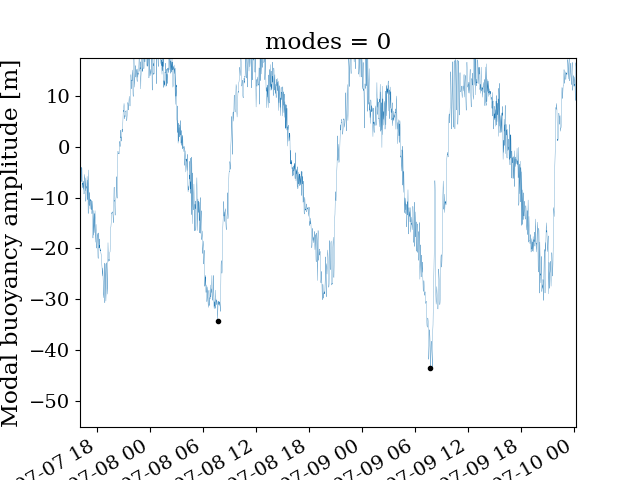

In [7]:
# Find the A_max over one day blocks
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

Amax_all = []
Amax_time = []
for t1 in time:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

# Load the stratification data

In [277]:
#ds_S = xr.open_dataset('../inputs/Crux_KP150_12mth_Density_lowpass_nliw.nc')
#ds_S['time'] += np.timedelta64(1,'D')

datadir = '../../run_ddcurves/DATA_SHELL/'
ds_S = xr.open_dataset('%s/ShellCrux_Uniltered_Density_BHM_VI_20162017_nliw.nc'%datadir,)
# Offset the time by one day
ds_S['time'] += np.timedelta64(1,'D')

#datadir = '../../run_ddcurves/DATA_SHELL/'
#ds_S = xr.open_dataset('%s/ShellCrux_Filtered_Density_BHM_MCMC_20162017_nliw.nc'%datadir,)
# Offset the time by one day
#ds_S['time'] += np.timedelta64(1,'D')

ds_S


<xarray.Dataset>
Dimensions:   (ensemble: 2000, params: 6, time: 374)
Coordinates:
  * time      (time) datetime64[ns] 2016-04-30T23:15:00 ... 2017-05-08T06:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    cn        (time, ensemble) float64 ...
    alpha     (time, ensemble) float64 ...
    beta      (params, time, ensemble) float64 ...

# Functions

 - ~~calc L_hat~~
 - ~~calc a_0~~
 - ~~calc zeta_hat (tidal amplitude envelope)~~
 - ~~extract alpha and c from stratification~~
 - ~~calc A_hat~~
 - ~~calc T_hat~~
 - Compute difference between A_hat  and A_observed

In [278]:
def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    zeros = np.zeros
    cos = np.cos
    sin = np.sin
    
    result = zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*cos(ff[ii] * t) + beta_s[2*ii+1]*sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

def calc_Ls(a0, omega, c, alpha):
    return c*c / (a0*omega*alpha)

def calc_Lhat(a0, omega, c, alpha, L):
    return calc_Ls(a0, omega, c, alpha) / L

def calc_zetahat(beta, omega, t):
    return sine_model_envelope(beta, omega, t)
    
def calc_a0(beta, zetahat):
    return beta[0] + beta[1]*zetahat

def calc_Ahat_That(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    return -Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat-LA)/(0.5*dLA)) )

def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat


def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1

    return Ahat


def calc_tlag(That, c, L):
    return L*That/c

def calc_tlag_nonlinear(That, c, L, alpha, A):
    c_nl = c+alpha*A
    return L*That/c_nl

def extract_alpha_c(ds, t):
    dsC = ds.sel(time=t, method='bfill')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    randint = np.random.randint(nsamples,size=nt)
    alpha = dsC.alpha.values[range(nt),randint]
    cn= dsC.cn.values[range(nt),randint]
    return alpha, cn

def extract_alpha_c_min(ds, t):
    dsC = ds.sel(time=t, method='nearest')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    alpha = dsC.alpha.values.min(axis=1)
    
    cn = np.zeros((nt,))
    for ii in range(nt):
        idx = np.argwhere(dsC.alpha.values[ii,:] == alpha[ii])[0,0]
        cn[ii]= dsC.cn.values[ii,idx]
    return alpha, cn



In [279]:
# Compute a0 for a given beta_0, beta_1 pair
# Needs to be computed iteratively

timein = ds_A.time.values
#timein = pd.date_range('2017-1-1','2017-4-20') 

timeinsec = SecondsSince(timein, basetime=basetime)
nt = timein.shape[0]
Amax_obs = ds_A.sel(time=timein, method='nearest')
#Amax_obs[Amax_obs>0] = -1*Amax_obs[Amax_obs>0]

# Givens
L = 1.5e5 # Length scale
omega0 = omega[0] # M2

# Need to guess That and beta
#Ahat_args = (3.0, 1.0, 1.0, 0.15)
#That_args = (-0.5, -1.0, 1.0, 0.30)

Ahat_args= (-2.68,-0.54)
That_args = (1.9,1.4,-0.34)
#That_args = (2.8,2.0,-0.34)


##
# Start of loop...

def compute_Ahat(beta, alpha, cn, L):

    That = np.zeros((nt,))
    a0 = np.zeros((nt,))
    
    for ii in range(6):

        # Compute the time lag
        #tlag = calc_tlag(That, cn, L)
        tlag = calc_tlag_nonlinear(That, cn, L, alpha, a0)


        # Compute a_0
        zetahat = calc_zetahat(beta_s, omega, timeinsec - tlag)
        a0 = calc_a0(beta, zetahat)
        
        # a0 needs to be the same sign as alpha
        #a0 *= np.sign(alpha)

        # Compute Ahat, Lhat
        Lhat = calc_Lhat(a0, omega0, cn, alpha, L)
        #Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
        #That = calc_Ahat_That_new(Lhat, That_args)
        
        Ahat = calc_Ahat_quadratic(Lhat, Ahat_args)
        That = calc_That_quadratic(Lhat, That_args)
        
        Amax = a0*Ahat
        
    return Lhat, That, Ahat, a0
    

def compute_Amax(beta, alpha, cn, L):
    # Get alpha, c
    Lhat, That, Ahat, a0 = compute_Ahat(beta, alpha, cn, L)

    return Ahat*a0

def compute_Amax_Aobs(beta, alpha, cn, L, Amax_obs):
    
    Amax_guess = compute_Amax(beta, alpha, cn, L)

    # Need to change the sign of the observed Amax to suit alpha
    my_Amax = 1*Amax_obs
    
    #signA = np.sign(Amax_guess)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #Amax_guess[idx] = -1*Amax_guess[idx]
    
    #signA = np.sign(my_Amax)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #my_Amax[idx] = -1*my_Amax[idx]
    
    return Amax_guess, my_Amax

def compute_Amax_error(beta, L,alpha, cn, Amax_obs):
    
    beta_a = [beta[0],beta[1]]
    #L = beta[2]*1e6
    
    Amax_guess, my_Amax = compute_Amax_Aobs(beta_a, alpha, cn, L, Amax_obs)
    
    # Compute the error
    #err = np.linalg.norm(my_Amax - Amax_guess)
    
    # Compute a weighted sum
    weight = my_Amax**3/np.sum(my_Amax**3)
    err = np.linalg.norm(weight*(my_Amax - Amax_guess))

    return err


#alpha, cn = extract_alpha_c(ds_S, timein)

#print(compute_Amax_error(beta0, alpha, cn, Amax_obs))




In [282]:
# Optimize to find beta's for a given alpha, cn
#alpha, cn = extract_alpha_c_min(ds_S, timein)
alpha, cn = extract_alpha_c(ds_S, timein) # Random selection


# Make sure alpha's sign aligns with the max or else we will never get convergence
signA = np.sign(Amax_obs)
signalpha= np.sign(alpha)
idx = signA != signalpha
my_Amax = 1*Amax_obs
my_Amax[idx] = -1*my_Amax[idx]

beta0 = [0.,0.,]

soln = minimize(compute_Amax_error, beta0, args = (L, alpha, cn, my_Amax),
               bounds=((1,25),(1,25),),)
soln

      fun: 4.440216613054681
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.95763414e-05, 5.95079541e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 20
   status: 0
  success: True
        x: array([ 7.78599837, 11.14699719])

<IPython.core.display.Javascript object>


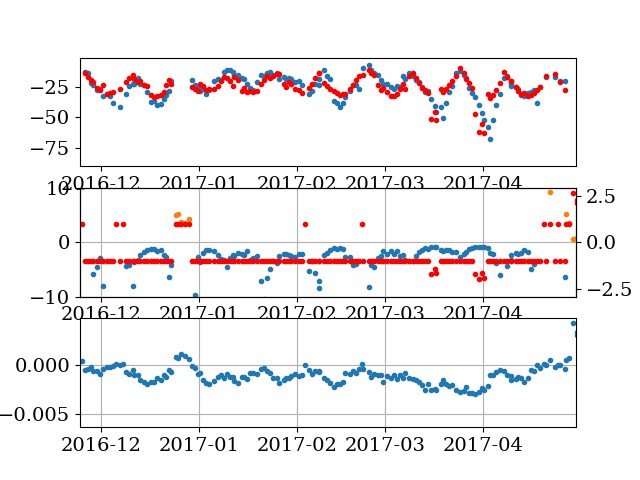

In [284]:
#Amax_guess = compute_Amax(soln['x'], alpha, cn)
#soln['x'] = [2,10.2,0.23]

Amax_guess, my_Amax = compute_Amax_Aobs(soln['x'][0:2], alpha, cn,  L,my_Amax)
Lhat, That, Ahat, a0 = compute_Ahat(soln['x'][0:2], alpha, cn, L)

plt.figure()
ax=plt.subplot(311)
plt.plot(timein, my_Amax,'.')
plt.plot(timein, Amax_guess,'r.')
#plt.plot(timein, a0,'g.')


plt.subplot(312,sharex=ax)
plt.plot(timein[Lhat<0], Lhat[Lhat<0],'.')
plt.plot(timein[Lhat>0], Lhat[Lhat>0],'.')

plt.ylim(-10,10)
plt.grid(b=True)

ax2 = plt.twinx()
ax2.plot(timein, Ahat,'r.')

plt.subplot(313,sharex=ax)
plt.plot(timein,alpha,'.')
plt.grid(b=True)


In [285]:
# Compute the solutions many times
niters = 500
betaa0 = np.zeros((niters,2))
Amax_optimal = np.zeros((niters,nt))
a0_optimal = np.zeros((niters,nt))
for ii in range(niters):
    alpha, cn = extract_alpha_c(ds_S, timein)
    
    # Make sure alpha's sign aligns with the max or else we will never get convergence
    signA = np.sign(Amax_obs)
    signalpha= np.sign(alpha)
    idx = signA != signalpha
    my_Amax = Amax_obs.copy()
    my_Amax[idx] = -1*my_Amax[idx]

    beta0 = [0.,0., ]

    soln = minimize(compute_Amax_error, beta0, args = (L,alpha, cn, my_Amax),
                   bounds=((1,20),(1,15),))
    
    Amax_guess, _ = compute_Amax_Aobs(soln['x'][0:2], alpha, cn, L, my_Amax)
    
    betaa0[ii,:] =soln['x']
    
    _, _, _, a0_optimal[ii,:] = compute_Ahat(soln['x'], alpha, cn, L)
    
    Amax_optimal[ii,:] = Amax_guess
    
    print(ii,soln['x'], soln['fun'])

0 [11.5069482   9.20866476] 4.303990497772005
1 [12.7378626   8.52301944] 4.674890911508381
2 [15.39521144  7.62463961] 4.366088567975015
3 [ 5.96431607 11.52145778] 4.146677370305159
4 [11.73228287  9.33549054] 4.1324555816409205
5 [10.88342726 10.01985866] 4.42881599257121
6 [14.3076867   8.40750625] 4.511559805056445
7 [10.00258695 10.31402507] 4.109750156380753
8 [11.30155982  9.30245133] 4.439609677640557
9 [10.70159725  9.81933172] 4.129979169603545
10 [10.38039559 10.01158246] 4.54966332595089
11 [ 9.40496852 10.35297198] 4.3599709199951615
12 [ 4.81457467 12.66548789] 4.127325225813837
13 [11.03964382  9.46983298] 4.056443436322929
14 [ 8.82650828 11.05185945] 3.7715930362456636
15 [10.61962187  9.55437795] 3.6992434923165223
16 [ 8.24154997 10.61352843] 3.9407002554304507
17 [ 6.4323895  11.35421833] 4.32654388691416
18 [11.57572719  9.32136315] 4.452240682789451
19 [15.32545865  7.07163972] 4.151238221709439
20 [10.45878516 10.25355518] 4.460213676891408
21 [12.24098459  9.15

173 [14.97541299  7.65083013] 4.36486458045703
174 [12.12957723  9.80292974] 3.8028854213002337
175 [13.78567401  8.3112926 ] 4.688750824463096
176 [ 5.63028708 12.17902868] 4.535399636171518
177 [16.57938027  7.18839433] 3.9636656472167764
178 [ 8.69103732 10.47891612] 4.047161109529683
179 [15.90983147  6.5545547 ] 4.125608286185468
180 [ 8.61861637 11.00209886] 4.053897900551609
181 [ 9.00045306 10.59416023] 4.30375210387072
182 [ 9.17331003 10.39772419] 3.917300790984863
183 [13.56318503  8.30274261] 4.057909990540922
184 [11.92326215  9.77219661] 4.2205915758273775
185 [10.1805629  10.27269481] 4.566172521749477
186 [ 1.         14.64793238] 4.109895665435532
187 [13.17050976  8.70407048] 4.345275756258263
188 [ 5.3885477  12.05534084] 4.134988079539074
189 [10.77197382  9.88239143] 4.46214357020145
190 [11.80838235  9.07375314] 4.102261517690718
191 [ 8.41080291 10.73876973] 4.071407456923522
192 [13.05390706  8.1223912 ] 3.876531288215113
193 [ 7.89734806 11.16710288] 4.21758658

344 [14.13409959  8.4894795 ] 4.293142145434662
345 [16.13587299  7.4552382 ] 4.525629526209881
346 [ 5.71720714 11.6691872 ] 4.120187208172121
347 [ 7.15256426 11.52278782] 4.130691634952901
348 [10.3526173  10.31871039] 4.156401424580213
349 [ 5.57319814 12.42190563] 3.8220973414550152
350 [ 9.29224897 10.47817095] 4.1502968057044365
351 [ 5.10236129 12.26216658] 4.028567620038639
352 [ 9.54377009 10.70703402] 4.290545639417252
353 [10.6596138   9.66188922] 3.9639560588538276
354 [11.9237455   8.88121544] 4.319594671795177
355 [13.82943449  7.84985567] 4.0548690797225575
356 [13.7550082   8.34656623] 4.0892053423560135
357 [ 5.98565392 11.52176005] 3.9715149345916303
358 [11.23278807  9.55792235] 4.5561598054033485
359 [13.77016789  7.91009968] 3.9577079675426
360 [14.39379468  8.0597178 ] 4.656824686177629
361 [ 9.34889018 10.29430873] 4.601862452056142
362 [11.53114045  9.71008218] 3.943535549334603
363 [10.65221743  9.56609681] 4.263235399673882
364 [14.79116058  7.27645233] 3.901

<IPython.core.display.Javascript object>


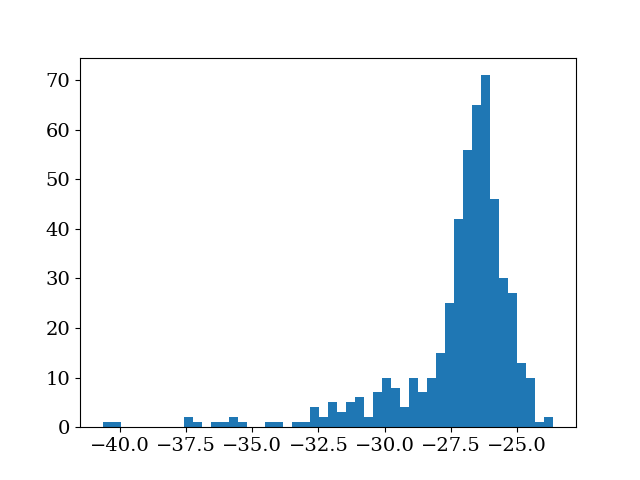

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,
         1.,  2.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  4.,  2.,  5.,
         3.,  5.,  6.,  2.,  7., 10.,  8.,  4., 10.,  7., 10., 15., 25.,
        42., 56., 65., 71., 46., 30., 27., 13., 10.,  1.,  2.]),
 array([-40.66793507, -40.32680631, -39.98567755, -39.64454879,
        -39.30342003, -38.96229127, -38.62116251, -38.28003375,
        -37.93890499, -37.59777623, -37.25664747, -36.91551871,
        -36.57438995, -36.23326119, -35.89213243, -35.55100367,
        -35.20987491, -34.86874615, -34.52761739, -34.18648863,
        -33.84535987, -33.50423111, -33.16310235, -32.82197359,
        -32.48084483, -32.13971607, -31.79858731, -31.45745855,
        -31.11632979, -30.77520103, -30.43407227, -30.09294351,
        -29.75181475, -29.41068599, -29.06955723, -28.72842846,
        -28.3872997 , -28.04617094, -27.70504218, -27.36391342,
        -27.02278466, -26.6816559 , -26.34052714, -25.99939838,
        -25.

In [286]:
plt.figure()
plt.hist(Amax_optimal[:,285],bins=50)
#plt.plot(alpha)

<IPython.core.display.Javascript object>


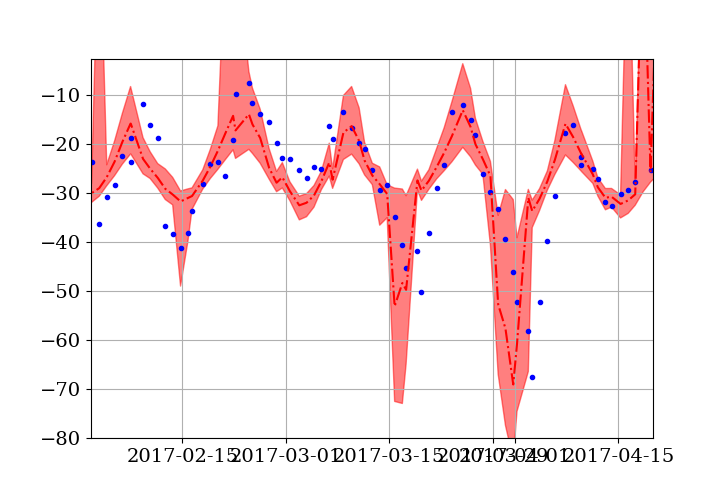

(-80, 80)

In [287]:
plt.figure()
#ax=plt.subplot(211)
plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(Amax_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(Amax_optimal,axis=0),
            np.max(Amax_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

plt.grid(b=True)
plt.ylim(-80,80)

<IPython.core.display.Javascript object>


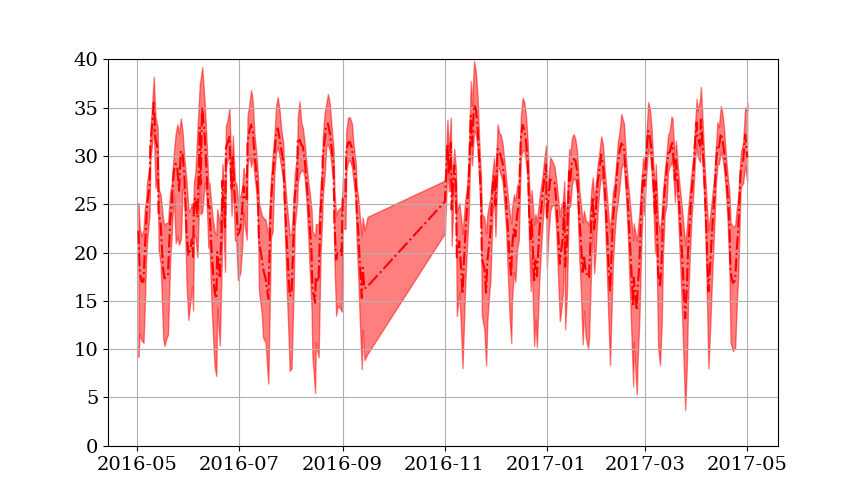

(0, 40)

In [291]:
plt.figure()
#ax=plt.subplot(211)
#plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(a0_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(a0_optimal,axis=0),
            np.max(a0_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

ax2 = plt.twinx()

plt.grid(b=True)
plt.ylim(0,40)

<IPython.core.display.Javascript object>


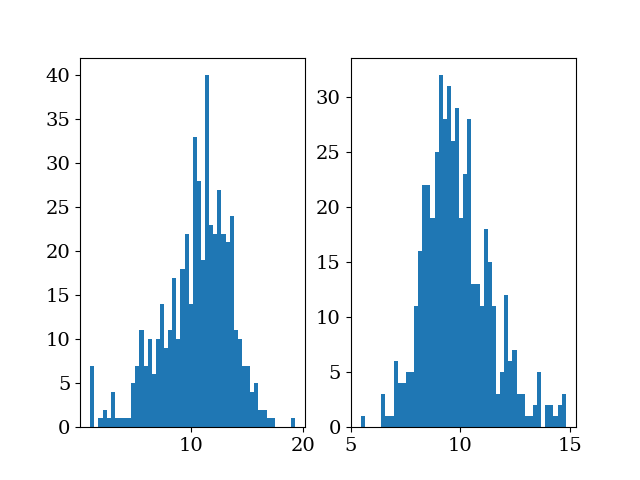

(array([ 1.,  0.,  0.,  0.,  0.,  3.,  1.,  1.,  6.,  4.,  4.,  5.,  5.,
        11., 16., 22., 22., 19., 25., 32., 28., 31., 26., 29., 19., 23.,
        28., 13., 13., 11., 18., 15., 11.,  3.,  5., 12.,  6.,  7.,  3.,
         3.,  1.,  1.,  2.,  5.,  0.,  2.,  2.,  1.,  2.,  3.]),
 array([ 5.45764064,  5.64441252,  5.83118441,  6.0179563 ,  6.20472819,
         6.39150007,  6.57827196,  6.76504385,  6.95181574,  7.13858762,
         7.32535951,  7.5121314 ,  7.69890329,  7.88567517,  8.07244706,
         8.25921895,  8.44599084,  8.63276272,  8.81953461,  9.0063065 ,
         9.19307839,  9.37985027,  9.56662216,  9.75339405,  9.94016594,
        10.12693782, 10.31370971, 10.5004816 , 10.68725349, 10.87402537,
        11.06079726, 11.24756915, 11.43434104, 11.62111292, 11.80788481,
        11.9946567 , 12.18142859, 12.36820047, 12.55497236, 12.74174425,
        12.92851614, 13.11528802, 13.30205991, 13.4888318 , 13.67560369,
        13.86237557, 14.04914746, 14.23591935, 14.42269124,

In [292]:
plt.figure()
plt.subplot(121)
plt.hist(betaa0[:,0], bins=50)

plt.subplot(122)
plt.hist(betaa0[:,1], bins=50)

#plt.subplot(133)
#plt.hist(betaa0[:,2], bins=50)

In [293]:
# Output the beta terms for later prediciton
outputh5 = '../inputs/a0_betas_Crux.h5'
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-beta',data=betaa0)
f.close()

<IPython.core.display.Javascript object>


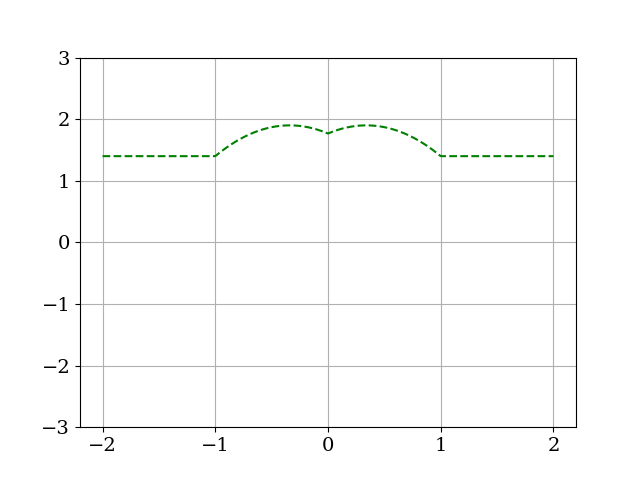

In [239]:
# Test the A_hat function
Lhat = np.linspace(-2,2,500)
def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat

def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1


    return Ahat


#Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
#Ahat_g = calc_Ahat_quadratic(Lhat,(-2.68,-0.54))
Ahat_g = calc_That_quadratic(Lhat,(1.9,1.4,-0.34))


plt.figure()
#plt.plot(Lhat,Ahat,'r--')
                                 
plt.plot(Lhat,Ahat_g,'g--')
plt.ylim(-3,3)
plt.grid(b=True)